# Universidad del Valle de Guatemala
# Inteligencia Artificial - CC3045
## Authors:
## Julio Herrera - 19402
## Juan Pablo Pineda - 19087
## Diego Crespo - 19541

### Dataset:
#### games_of_all_time.csv - Games of All Time from Metacritic - https://www.kaggle.com/datasets/xcherry/games-of-all-time-from-metacritic?resource=download
#### vgsales.csv - Video Game Sales - https://www.kaggle.com/datasets/gregorut/videogamesales

In [75]:
import pandas as pd
from ast import literal_eval
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress, pearsonr
import random

In [76]:
games_meta = pd.read_csv('games_of_all_time.csv')
games_sales = pd.read_csv('vgsales.csv')

# Juntando datasets

Removiendo variables que no se usarán

In [77]:
games_meta = games_meta.drop(columns=['description', 'url', 'type', 'rating'])
games_sales = games_sales.drop(columns=['Rank', 'Genre', 'Publisher'])

Renombrando variables para facilitar su lectura

In [78]:
games_meta.columns = ['name', 'meta_score', 'user_score', 'platform', 'developer', 'genre']
games_sales.columns = ['name', 'platform', 'year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

Limpiando datos

In [79]:
# remove the 'HD' at the end of the name on every row
games_sales['name'] = games_sales['name'].str.replace(' HD', '')
games_sales['name'] = games_sales['name'].str.replace(' 3D', '')
games_meta['name'] = games_meta['name'].str.replace(' HD', '')
games_meta['name'] = games_meta['name'].str.replace(' 3D', '')

# create new rows by separating the platforms list
games_meta['platform'] = games_meta['platform'].apply(literal_eval)
games_meta = games_meta.explode('platform')

# drop columns with na value in genre and developer column
games_meta = games_meta.dropna(subset=['genre'])
games_meta = games_meta.dropna(subset=['developer'])

# create new rows by separating the genre list
games_meta['genre'] = games_meta['genre'].apply(literal_eval)
games_meta = games_meta.explode('genre')

# if platform is '3ds' change to '3DS' without using replace
games_meta['platform'] = games_meta['platform'].apply(lambda x: '3DS' if x == '3ds' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'N64' if x == 'nintendo-64' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'XB' if x == 'xbox' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'X360' if x == 'xbox-360' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'XOne' if x == 'xbox-one' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'PS' if x == 'playstation' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'PS2' if x == 'playstation-2' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'PS3' if x == 'playstation-3' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'PS4' if x == 'playstation-4' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'PSV' if x == 'playstation-vita' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'PSP' if x == 'psp' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'PC' if x == 'pc' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'Wii' if x == 'wii' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'WiiU' if x == 'wii-u' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'GC' if x == 'gamecube' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'DS' if x == 'ds' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'DC' if x == 'dreamcast' else x)
games_meta['platform'] = games_meta['platform'].apply(lambda x: 'GBA' if x == 'game-boy-advance' else x)

In [80]:
# Mergeando ambos datasets
games_meta_sales = pd.merge(games_meta, games_sales, on=['name', 'platform'])
games_meta_sales

,name,meta_score,user_score,platform,developer,genre,year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,The Legend of Zelda: Ocarina of Time,99.0,91.0,N64,Nintendo,Action Adventure,1998.0,4.10,1.89,1.45,0.16,7.60
1,The Legend of Zelda: Ocarina of Time,99.0,91.0,N64,Nintendo,Fantasy,1998.0,4.10,1.89,1.45,0.16,7.60
2,Super Mario Galaxy,97.0,91.0,Wii,Nintendo,Action,2007.0,6.16,3.40,1.20,0.76,11.52
3,Super Mario Galaxy,97.0,91.0,Wii,Nintendo,Platformer,2007.0,6.16,3.40,1.20,0.76,11.52
4,Super Mario Galaxy,97.0,91.0,Wii,Nintendo,3D,2007.0,6.16,3.40,1.20,0.76,11.52
...,...,...,...,...,...,...,...,...,...,...,...,...
15754,htoL#NiQ: The Firefly Diary,58.0,75.0,PSV,Nippon Ichi Software,General,2014.0,0.00,0.00,0.01,0.00,0.01
15755,htoL#NiQ: The Firefly Diary,58.0,75.0,PSV,Nippon Ichi Software,Platformer,2014.0,0.00,0.00,0.01,0.00,0.01
15756,htoL#NiQ: The Firefly Diary,58.0,75.0,PSV,Nippon Ichi Software,2D,2014.0,0.00,0.00,0.01,0.00,0.01
15757,uDraw Studio,71.0,71.0,Wii,THQ,Miscellaneous,2010.0,1.67,0.58,0.00,0.20,2.46


Categorizando

In [81]:
# Categorise values in platform column
platforms = games_meta_sales['platform'].values
platforms = np.unique(platforms)
platforms_dict = {}
for i in range(len(platforms)):
    platforms_dict[platforms[i]] = i
games_meta_sales['platform'] = games_meta_sales['platform'].apply(lambda x: platforms_dict[x])

In [82]:
# Categorise values in genre column
genres = games_meta_sales['genre'].values
genres = np.unique(genres)
genres_dict = {}
for i in range(len(genres)):
    genres_dict[genres[i]] = i
games_meta_sales['genre'] = games_meta_sales['genre'].apply(lambda x: genres_dict[x])

In [83]:
# Categorise values in developer column
developer = games_meta_sales['developer'].values
developer_dict = np.unique(developer)
developer_dict = {}
for i in range(len(developer)):
    developer_dict[developer[i]] = i
games_meta_sales['developer'] = games_meta_sales['developer'].apply(lambda x: developer_dict[x])
games_meta_sales

,name,meta_score,user_score,platform,developer,genre,year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,The Legend of Zelda: Ocarina of Time,99.0,91.0,5,15445,4,1998.0,4.10,1.89,1.45,0.16,7.60
1,The Legend of Zelda: Ocarina of Time,99.0,91.0,5,15445,40,1998.0,4.10,1.89,1.45,0.16,7.60
2,Super Mario Galaxy,97.0,91.0,13,15445,3,2007.0,6.16,3.40,1.20,0.76,11.52
3,Super Mario Galaxy,97.0,91.0,13,15445,96,2007.0,6.16,3.40,1.20,0.76,11.52
4,Super Mario Galaxy,97.0,91.0,13,15445,1,2007.0,6.16,3.40,1.20,0.76,11.52
...,...,...,...,...,...,...,...,...,...,...,...,...
15754,htoL#NiQ: The Firefly Diary,58.0,75.0,12,15756,51,2014.0,0.00,0.00,0.01,0.00,0.01
15755,htoL#NiQ: The Firefly Diary,58.0,75.0,12,15756,96,2014.0,0.00,0.00,0.01,0.00,0.01
15756,htoL#NiQ: The Firefly Diary,58.0,75.0,12,15756,0,2014.0,0.00,0.00,0.01,0.00,0.01
15757,uDraw Studio,71.0,71.0,13,15758,77,2010.0,1.67,0.58,0.00,0.20,2.46


# Analisis de variables

In [84]:
printAnalisis = True

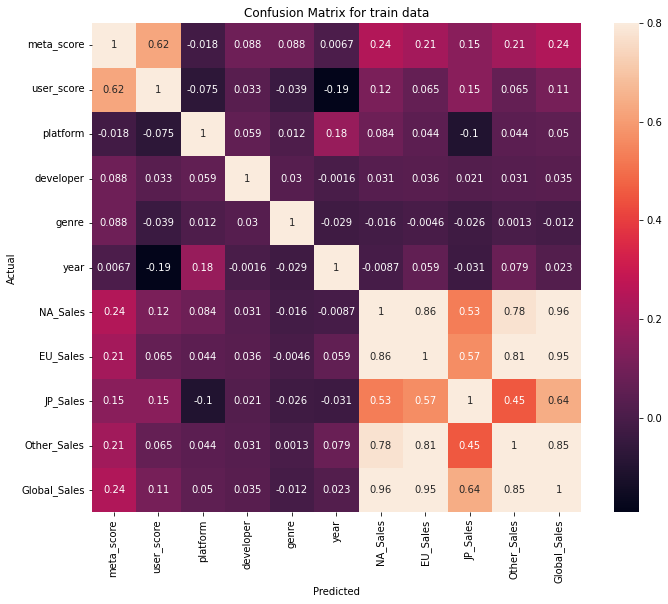

In [85]:
if printAnalisis:
    # Correlation matrix
    corr_matrix = games_meta_sales.corr()
    plt.figure(figsize=(12, 9))
    sns.heatmap(corr_matrix, vmax=0.8, square=True, annot=True)
    plt.title('Confusion Matrix for train data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [86]:
# Cleaning inf and nan values
graphVars = ['meta_score', 'user_score', 'platform', 'genre', 'developer', 'year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
if printAnalisis:
    for col in graphVars:
        if np.isnan(games_meta_sales[col]).any():
            games_meta_sales[col] = np.nan_to_num(games_meta_sales[col])

Revisando datos atipicos en ventas

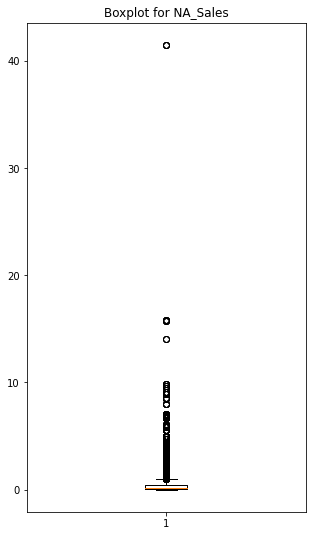

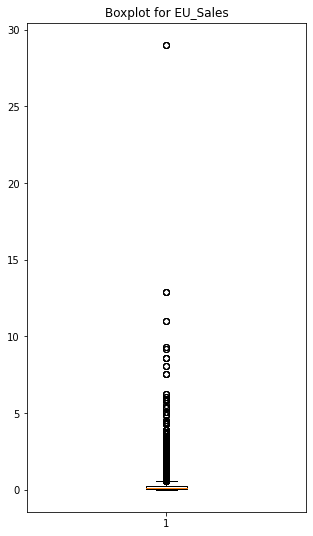

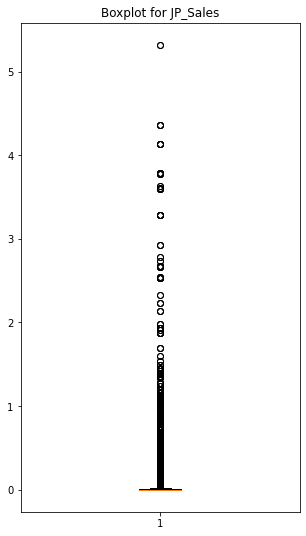

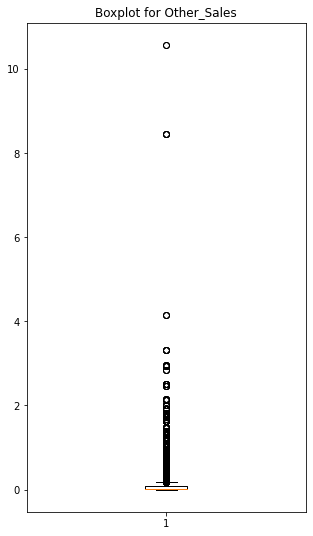

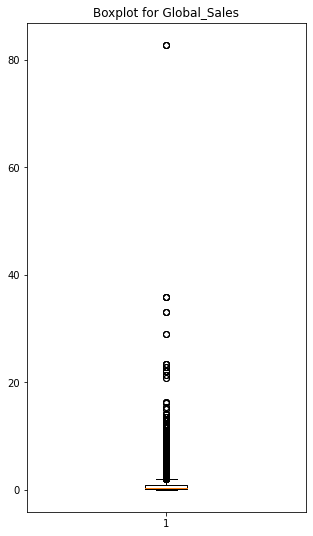

In [87]:
graphVars = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
if printAnalisis:
    for i in graphVars:
        # boxplot
        plt.figure(figsize=(5, 9))
        plt.boxplot(games_meta_sales[i])
        plt.title('Boxplot for ' + i)
        plt.show()

Removiendo datos atipicos de ventas

In [88]:
games_meta_sales = games_meta_sales[games_meta_sales['NA_Sales'] <= 11]
games_meta_sales = games_meta_sales[games_meta_sales['EU_Sales'] <= 10]
games_meta_sales = games_meta_sales[games_meta_sales['JP_Sales'] <= 3]
games_meta_sales = games_meta_sales[games_meta_sales['Other_Sales'] <= 3]
games_meta_sales = games_meta_sales[games_meta_sales['Global_Sales'] <= 20]

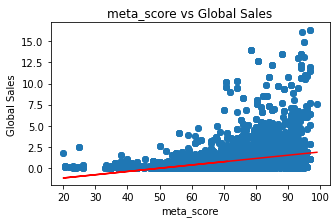

meta_score vs Global Sales: Pearson Correlation Coefficient: 0.3431351249617914
meta_score vs Global Sales: p-value: 0.0


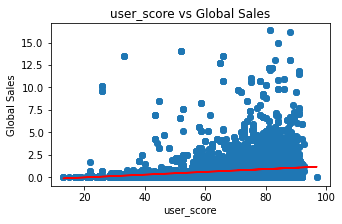

user_score vs Global Sales: Pearson Correlation Coefficient: 0.1303219452032923
user_score vs Global Sales: p-value: 1.7990579225153507e-60


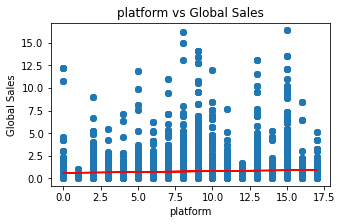

platform vs Global Sales: Pearson Correlation Coefficient: 0.06149339406884187
platform vs Global Sales: p-value: 1.2147005444456585e-14


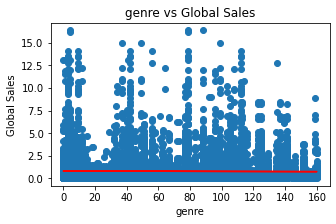

genre vs Global Sales: Pearson Correlation Coefficient: -0.01470119646280976
genre vs Global Sales: p-value: 0.06537972203635341


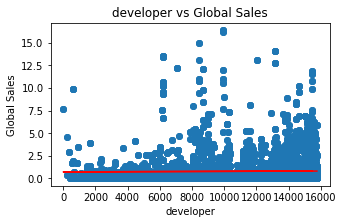

developer vs Global Sales: Pearson Correlation Coefficient: 0.014905562076697906
developer vs Global Sales: p-value: 0.06172432582642953


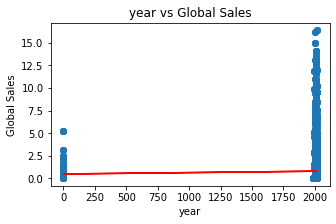

year vs Global Sales: Pearson Correlation Coefficient: 0.02882027924964735
year vs Global Sales: p-value: 0.0003027932915892241


In [89]:
# graph all vars vs global sales
graphVars = ['meta_score', 'user_score', 'platform', 'genre', 'developer', 'year']
if printAnalisis:
    for i in graphVars:
        # current variable vs global sales
        plt.figure(figsize=(5, 3))
        plt.scatter(games_meta_sales[i], games_meta_sales['Global_Sales'])
        slope, intercept, r_value, p_value, std_err = linregress(games_meta_sales[i], games_meta_sales['Global_Sales'])
        line = slope * games_meta_sales[i] + intercept
        plt.plot(games_meta_sales[i], line, color='red')
        plt.title('{} vs Global Sales'.format(i))
        plt.xlabel('{}'.format(i))
        plt.ylabel('Global Sales')
        plt.show()
        pearson_coef, p_value = pearsonr(games_meta_sales[i], games_meta_sales['Global_Sales'])
        print('{} vs Global Sales: Pearson Correlation Coefficient: {}'.format(i, pearson_coef))
        print('{} vs Global Sales: p-value: {}'.format(i, p_value))

Eliminando la columna genero y developer, así como los datos duplicados que deja

In [90]:
games_meta_sales.drop(['genre'], axis=1, inplace=True)
games_meta_sales.drop(['developer'], axis=1, inplace=True)
# remove full duplicated rows
games_meta_sales = games_meta_sales.drop_duplicates(subset=['name', 'platform', 'meta_score', 'user_score', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], keep='first')
games_meta_sales

,name,meta_score,user_score,platform,year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,The Legend of Zelda: Ocarina of Time,99.0,91.0,5,1998.0,4.10,1.89,1.45,0.16,7.60
2,Super Mario Galaxy,97.0,91.0,13,2007.0,6.16,3.40,1.20,0.76,11.52
5,Super Mario Galaxy 2,97.0,91.0,13,2010.0,3.66,2.42,0.98,0.64,7.69
8,Metroid Prime,97.0,89.0,4,2002.0,1.96,0.67,0.10,0.09,2.82
12,Halo: Combat Evolved,97.0,87.0,16,2001.0,4.98,1.30,0.08,0.07,6.43
...,...,...,...,...,...,...,...,...,...,...
15739,de Blob 2,74.0,72.2,2,2011.0,0.09,0.02,0.00,0.01,0.12
15744,de Blob 2,74.0,72.2,9,2011.0,0.11,0.07,0.00,0.03,0.21
15749,echochrome,79.0,79.0,11,2008.0,0.00,0.01,0.08,0.00,0.09
15753,htoL#NiQ: The Firefly Diary,58.0,75.0,12,2014.0,0.00,0.00,0.01,0.00,0.01


Quitando registros con año 0

In [91]:
# drop rows where year is less than 1990
games_meta_sales = games_meta_sales[games_meta_sales['year'] >= 1990]
games_meta_sales.describe()

,meta_score,user_score,platform,year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,4332.000000,4332.000000,4332.000000,4332.000000,4332.000000,4332.000000,4332.000000,4332.000000,4332.000000
mean,71.563913,72.308818,9.084488,2006.946214,0.401729,0.236438,0.060390,0.079162,0.777920
std,12.933779,12.158842,4.616712,4.177610,0.755429,0.517553,0.208808,0.186905,1.432137
min,20.000000,13.000000,0.000000,1996.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,63.000000,66.000000,6.000000,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000
50%,74.000000,75.000000,9.000000,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000
75%,81.000000,81.000000,13.000000,2010.000000,0.410000,0.210000,0.020000,0.070000,0.800000
max,99.000000,97.000000,17.000000,2016.000000,9.630000,6.210000,2.780000,2.930000,16.380000


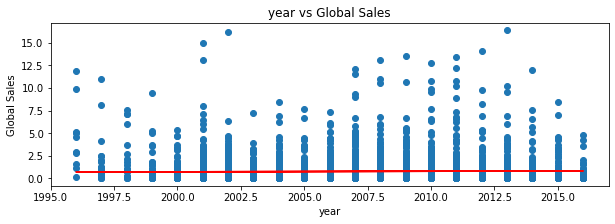

year vs Global Sales: Pearson Correlation Coefficient: 0.016672796021478448
year vs Global Sales: p-value: 0.2725852241568882


In [92]:
graphVars = ['year']
if printAnalisis:
    for i in graphVars:
        # current variable vs global sales
        plt.figure(figsize=(10, 3))
        plt.scatter(games_meta_sales[i], games_meta_sales['Global_Sales'])
        slope, intercept, r_value, p_value, std_err = linregress(games_meta_sales[i], games_meta_sales['Global_Sales'])
        line = slope * games_meta_sales[i] + intercept
        plt.plot(games_meta_sales[i], line, color='red')
        plt.title('{} vs Global Sales'.format(i))
        plt.xlabel('{}'.format(i))
        plt.ylabel('Global Sales')
        plt.show()
        pearson_coef, p_value = pearsonr(games_meta_sales[i], games_meta_sales['Global_Sales'])
        print('{} vs Global Sales: Pearson Correlation Coefficient: {}'.format(i, pearson_coef))
        print('{} vs Global Sales: p-value: {}'.format(i, p_value))

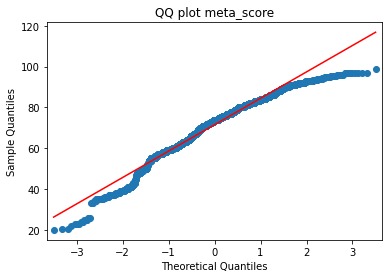

skew:  -0.6900625509399992
kurtosis:  0.4576112276926452


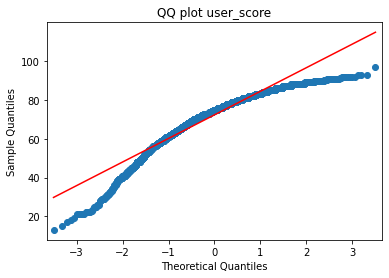

skew:  -1.2447611325537924
kurtosis:  2.0379105368234445


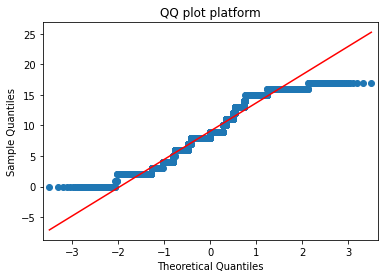

skew:  0.015592349635656106
kurtosis:  -1.0370606341283388


In [93]:
graphVars = ['meta_score', 'user_score', 'platform']
if printAnalisis:
    for i in graphVars:
        qqplot(games_meta_sales[i], line='s')
        plt.title(f'QQ plot {i}')
        plt.show()
        print('skew: ', games_meta_sales[i].skew())
        print('kurtosis: ', games_meta_sales[i].kurtosis())

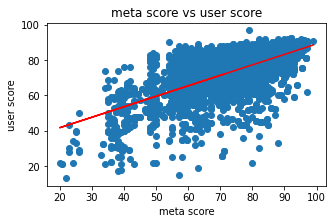

meta score vs user score: Pearson Correlation Coefficient: 0.6311859505840607
meta score vs user score: p-value: 0.0


In [94]:
# graph meta score vs user score
if printAnalisis:
    plt.figure(figsize=(5, 3))
    plt.scatter(games_meta_sales['meta_score'], games_meta_sales['user_score'])
    slope, intercept, r_value, p_value, std_err = linregress(games_meta_sales['meta_score'], games_meta_sales['user_score'])
    line = slope * games_meta_sales['meta_score'] + intercept
    plt.plot(games_meta_sales['meta_score'], line, color='red')
    plt.title('meta score vs user score')
    plt.xlabel('meta score')
    plt.ylabel('user score')
    plt.show()
    pearson_coef, p_value = pearsonr(games_meta_sales['meta_score'], games_meta_sales['user_score'])
    print('meta score vs user score: Pearson Correlation Coefficient: {}'.format(pearson_coef))
    print('meta score vs user score: p-value: {}'.format(p_value))

# Aplicando modelo de RNA

In [95]:
# Y is sales of different regions
Y = games_meta_sales[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].values
Y

array([[4.100e+00, 1.890e+00, 1.450e+00, 1.600e-01, 7.600e+00],
       [6.160e+00, 3.400e+00, 1.200e+00, 7.600e-01, 1.152e+01],
       [3.660e+00, 2.420e+00, 9.800e-01, 6.400e-01, 7.690e+00],
       ...,
       [0.000e+00, 1.000e-02, 8.000e-02, 0.000e+00, 9.000e-02],
       [0.000e+00, 0.000e+00, 1.000e-02, 0.000e+00, 1.000e-02],
       [1.670e+00, 5.800e-01, 0.000e+00, 2.000e-01, 2.460e+00]])

In [96]:
X = games_meta_sales[['meta_score', 'user_score', 'platform']].values
X

array([[99., 91.,  5.],
       [97., 91., 13.],
       [97., 91., 13.],
       ...,
       [79., 79., 11.],
       [58., 75., 12.],
       [71., 71., 13.]])

In [97]:
np.random.seed(0)
random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3032, 3) (3032, 5)
(1300, 3) (1300, 5)


In [98]:
hidden_layers = (800, 1000, 500, 250, 100)
activation = 'relu'
lri = 0.000001
tol = 0.001
max_iter = 100000

rna_model = MLPRegressor(hidden_layer_sizes=hidden_layers, activation=activation, learning_rate_init=lri, max_iter=max_iter, verbose=True, random_state=0, tol=tol)
# TODO: grafica de la perdida

# x_train values to integers
x_train = x_train.astype('int')
rna_model.fit(x_train, y_train)

Iteration 1, loss = 4.75225932
Iteration 2, loss = 4.05973702
Iteration 3, loss = 3.46776961
Iteration 4, loss = 2.96394429
Iteration 5, loss = 2.54473481
Iteration 6, loss = 2.19249208
Iteration 7, loss = 1.88809567
Iteration 8, loss = 1.63164809
Iteration 9, loss = 1.41637187
Iteration 10, loss = 1.23272035
Iteration 11, loss = 1.07255671
Iteration 12, loss = 0.93183376
Iteration 13, loss = 0.81647361
Iteration 14, loss = 0.72386990
Iteration 15, loss = 0.64992486
Iteration 16, loss = 0.58903181
Iteration 17, loss = 0.53732413
Iteration 18, loss = 0.49415372
Iteration 19, loss = 0.45773143
Iteration 20, loss = 0.42686717
Iteration 21, loss = 0.40151035
Iteration 22, loss = 0.38054495
Iteration 23, loss = 0.36302318
Iteration 24, loss = 0.34909419
Iteration 25, loss = 0.33725898
Iteration 26, loss = 0.32818230
Iteration 27, loss = 0.32082361
Iteration 28, loss = 0.31523145
Iteration 29, loss = 0.31088455
Iteration 30, loss = 0.30711531
Iteration 31, loss = 0.30416092
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(800, 1000, 500, 250, 100),
             learning_rate_init=1e-06, max_iter=100000, random_state=0,
             tol=0.001, verbose=True)

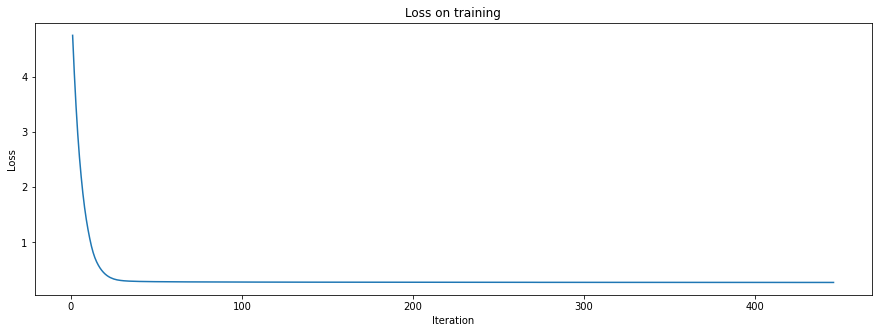

In [99]:
lossData = pd.read_csv('loss.csv')
# plot iteartion vs loss
iteration = lossData['x']
loss = lossData['y']
plt.figure(figsize=(15, 5))
plt.plot(iteration, loss)
plt.title('Loss on training')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [100]:
# x_train values to integers
x_test = x_test.astype('int')
y_pred = rna_model.predict(x_test)
y_pred

array([[0.37100448, 0.18579989, 0.07614804, 0.08775611, 0.6914386 ],
       [0.4591886 , 0.25100998, 0.05025377, 0.12001241, 0.90214105],
       [0.53039469, 0.35777959, 0.06102525, 0.09985701, 1.02820896],
       ...,
       [0.33496431, 0.26630534, 0.11127141, 0.05801289, 0.62845308],
       [0.34635774, 0.24884078, 0.1241903 , 0.02859053, 0.57259334],
       [0.66637666, 0.43961134, 0.05090416, 0.19978894, 1.12693692]])

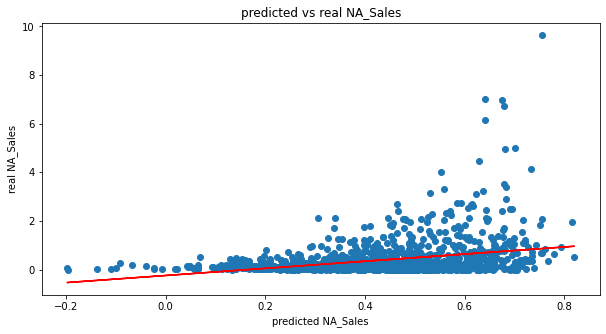

NA_Sales vs Global Sales: Pearson Correlation Coefficient: 0.3205736392021848
NA_Sales vs Global Sales: p-value: 1.8697250051172146e-32


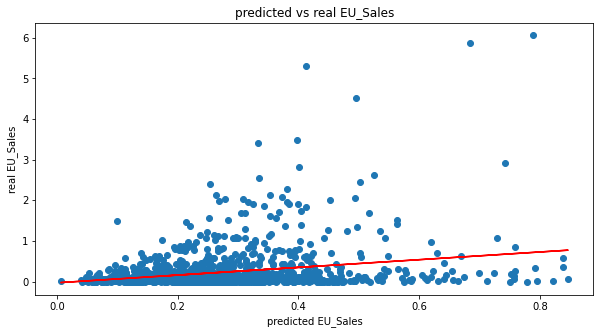

EU_Sales vs Global Sales: Pearson Correlation Coefficient: 0.2531253090539705
EU_Sales vs Global Sales: p-value: 1.8765060657812406e-20


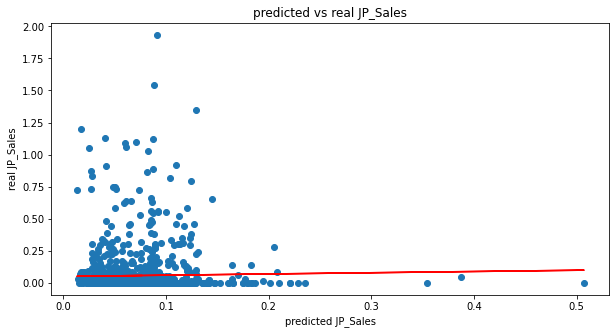

JP_Sales vs Global Sales: Pearson Correlation Coefficient: 0.020757633799631716
JP_Sales vs Global Sales: p-value: 0.45458819998399874


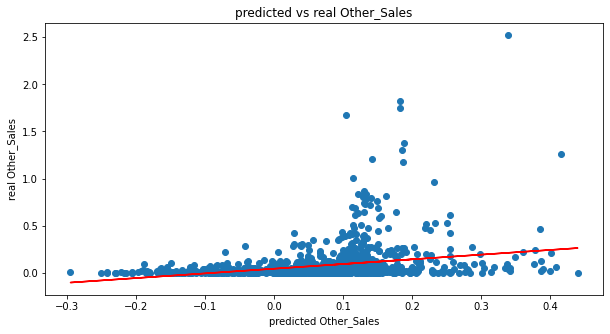

Other_Sales vs Global Sales: Pearson Correlation Coefficient: 0.2697521503297215
Other_Sales vs Global Sales: p-value: 4.1296745453686826e-23


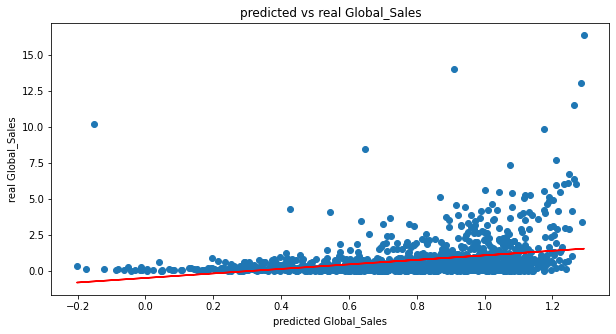

Global_Sales vs Global Sales: Pearson Correlation Coefficient: 0.3192196214725262
Global_Sales vs Global Sales: p-value: 3.5123289418756416e-32


In [101]:
# graph predicted vs real
graphVars = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
for i in graphVars:
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred[:, graphVars.index(i)], y_test[:, graphVars.index(i)])
    slope, intercept, r_value, p_value, std_err = linregress(y_pred[:, graphVars.index(i)], y_test[:, graphVars.index(i)])
    line = slope * y_pred[:, graphVars.index(i)] + intercept
    plt.plot(y_pred[:, graphVars.index(i)], line, color='red')
    plt.title('predicted vs real {}'.format(i))
    plt.xlabel('predicted {}'.format(i))
    plt.ylabel('real {}'.format(i))
    plt.show()
    pearson_coef, p_value = pearsonr(y_pred[:, graphVars.index(i)], y_test[:, graphVars.index(i)])
    print('{} vs Global Sales: Pearson Correlation Coefficient: {}'.format(i, pearson_coef))
    print('{} vs Global Sales: p-value: {}'.format(i, p_value))

In [102]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('mse: ', mse)
print('r2: ', r2)

mse:  0.48469207193605757
r2:  0.03648341570291551
